ランタイムはT4 GPU以上のものを選択
Colabの実行方法に関してはあんまり調べていないから、Google Driveに永続化したい環境をおいてランタイムにマウントしてつかうみたいなより良い方法があるかもしれないが、各自調べて下さい。
Colabのラインタイムにはどうやら100GiBディスクがあるようなので今回の場合は足りなくなることはなさそうだが、モデルやデータセットを置けなくなったら、`HF_HUB_CACHE`をGoogle Driveをマウントしている場所に指定すれば多分解決できる


ColabのUIからcloneしたPythonのファイルを編集可能なので、カスタマイズも可能。だし、uvではなくpipでライブラリを入れればリポジトリ内のモジュールのインポートも可能なので割と何でもできる。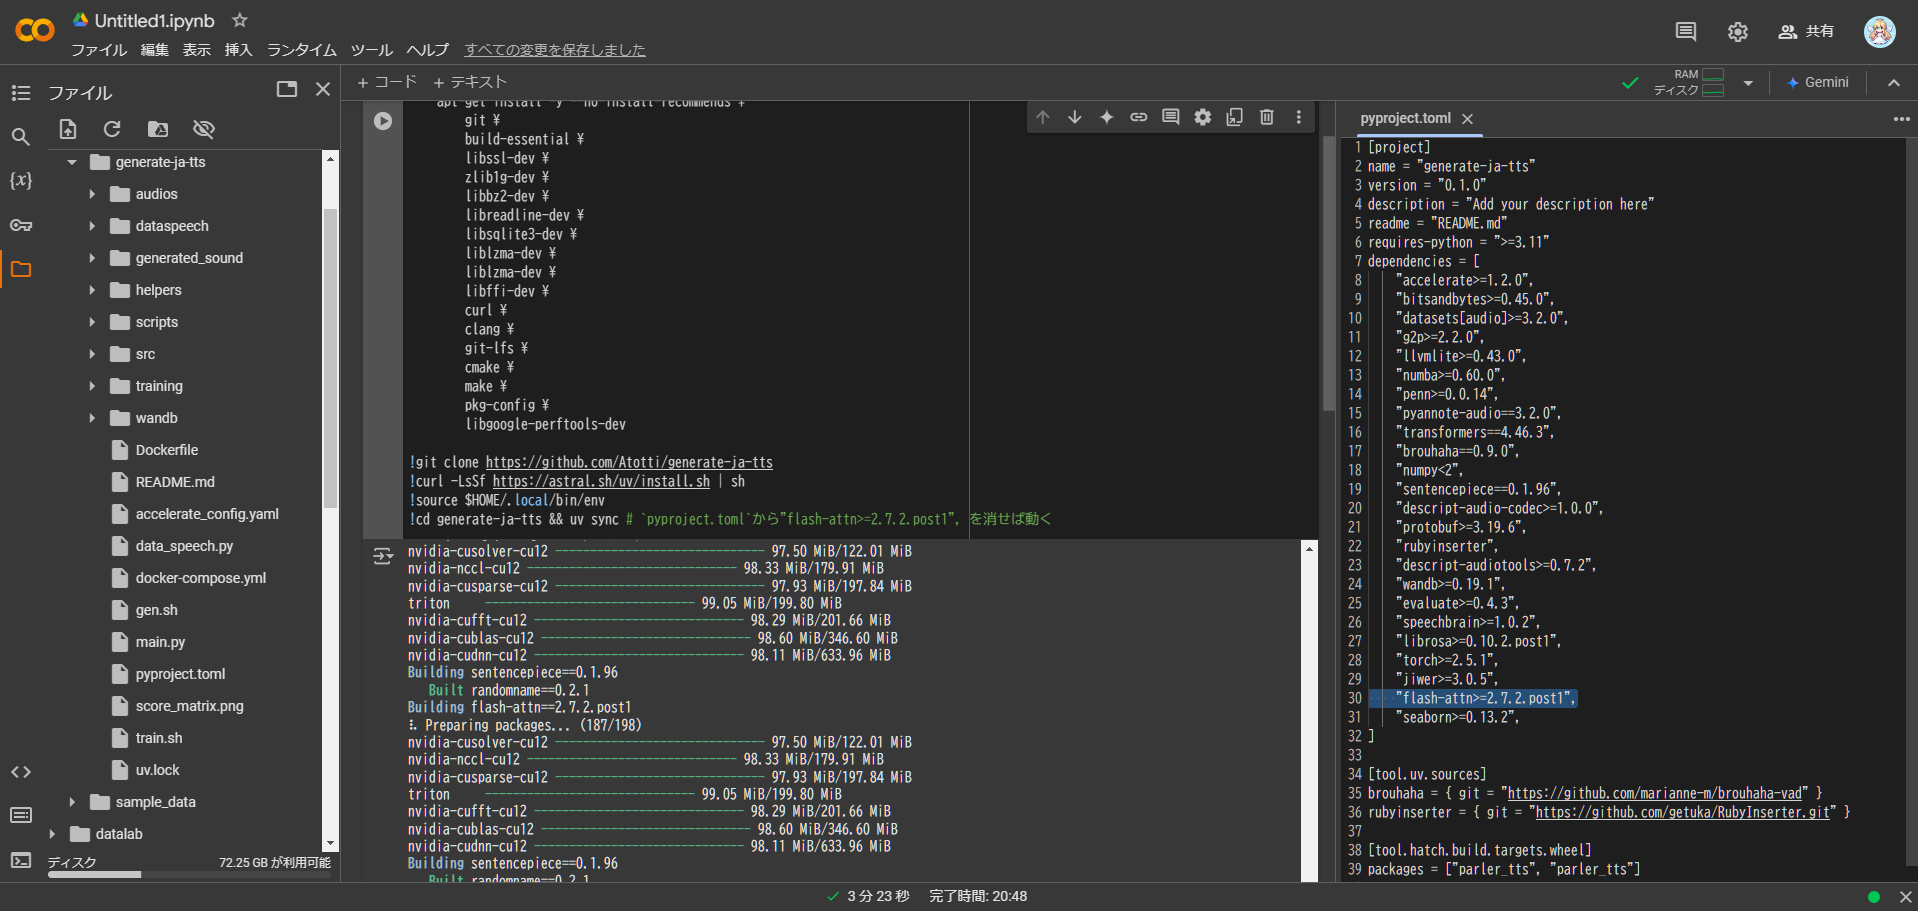

In [3]:
# 環境構築 /content/generate-ja-ttsにリポジトリがクローンされる

!apt-get -y update && apt-get -y upgrade && \
    apt-get install -y --no-install-recommends \
        git \
        build-essential \
        libssl-dev \
        zlib1g-dev \
        libbz2-dev \
        libreadline-dev \
        libsqlite3-dev \
        liblzma-dev \
        liblzma-dev \
        libffi-dev \
        curl \
        clang \
        git-lfs \
        cmake \
        make \
        pkg-config \
        libgoogle-perftools-dev

!git clone https://github.com/Atotti/generate-ja-tts
!curl -LsSf https://astral.sh/uv/install.sh | sh
!source $HOME/.local/bin/env
!cd generate-ja-tts && uv sync # `pyproject.toml`から"flash-attn>=2.7.2.post1", を消せばとりあえず動く。なんでflash-attnのインストールに失敗するのかはあまり調べていない

ストリーミング出力は最後の 5000 行に切り捨てられました。
nvidia-cudnn-cu12 ------------------------------ 174.65 MiB/633.96 MiB
Building sentencepiece==0.1.96
   Built unidic-lite==1.0.8
⠹ Preparing packages... (2/10)
nvidia-nccl-cu12 ------------------------------ 177.99 MiB/179.91 MiB
nvidia-cusparse-cu12 ------------------------------ 181.12 MiB/197.84 MiB
triton     ------------------------------ 164.90 MiB/199.80 MiB
nvidia-cufft-cu12 ------------------------------ 180.30 MiB/201.66 MiB
nvidia-cublas-cu12 ------------------------------ 181.54 MiB/346.60 MiB
nvidia-cudnn-cu12 ------------------------------ 174.95 MiB/633.96 MiB
Building sentencepiece==0.1.96
   Built unidic-lite==1.0.8
⠸ Preparing packages... (2/10)
nvidia-nccl-cu12 ------------------------------ 177.99 MiB/179.91 MiB
nvidia-cusparse-cu12 ------------------------------ 181.12 MiB/197.84 MiB
triton     ------------------------------ 164.90 MiB/199.80 MiB
nvidia-cufft-cu12 ------------------------------ 180.30 MiB/201.66 MiB
nvidia-cublas-cu

In [4]:
!uv run huggingface-cli login # ダブルクリックでinput fieldが開く


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `jsut` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when push

## 後は基本READMEに書いてある通りに動かせる。例として合成音の生成と finetuningの例を載せる

In [6]:
# 合成音生成 このスクリプトの場合、/content/generate-ja-tts/generated_audios/<タイムスタンプ>.wavに出力される。UIからダウンロード可能
!cd generate-ja-tts && sh gen.sh

Flash attention 2 is not installed
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
Generating audio files with model Atotti/japanese-parler-tts-mini-jsut-voiceactress100...
Prompt: 今日の天気は？お父さんに電話をかけて
Description: Tomoko's words are delivered in a very monotone voice, with very poor recording, as the sounds are muffled by a very close-sounding environment. The pace of her speech is slow.
/content/generate-ja-tts/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
  "_name_or_path": "google/flan-t5-large",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2816,
  "d_kv": 64,
  "d_model

In [10]:
# Finetuning (面倒なのでwandbの設定はスキップ)

!cd generate-ja-tts && export WANDB_DISABLED=true && uv run accelerate launch ./training/run_parler_tts_training.py \
    --model_name_or_path "2121-8/japanese-parler-tts-mini-bate" \
    --feature_extractor_name "parler-tts/dac_44khZ_8kbps" \
    --description_tokenizer_name "2121-8/japanese-parler-tts-mini-bate" \
    --prompt_tokenizer_name "2121-8/japanese-parler-tts-mini-bate" \
    --overwrite_output_dir true \
    --train_dataset_name "Atotti/jsut-voiceactress100-datasets" \
    --train_metadata_dataset_name "Atotti/jsut-voiceactress100-descriptions" \
    --train_dataset_config_name "default" --train_split_name "train" \
    --eval_dataset_name "Atotti/jsut-voiceactress100-datasets" \
    --eval_metadata_dataset_name "Atotti/jsut-voiceactress100-descriptions" \
    --eval_dataset_config_name "default" \
    --eval_split_name "train" --max_eval_samples 8 \
    --per_device_eval_batch_size 4 \
    --target_audio_column_name "audio" \
    --description_column_name "text_description" \
    --prompt_column_name "text" \
    --max_duration_in_seconds 20 \
    --min_duration_in_seconds 2.0 \
    --max_text_length 400 \
    --preprocessing_num_workers 2 \
    --do_train true \
    --num_train_epochs 2 \
    --gradient_accumulation_steps 18 \
    --gradient_checkpointing true \
    --per_device_train_batch_size 2 \
    --learning_rate 0.0001 \
    --adam_beta1 0.9 \
    --adam_beta2 0.99 \
    --weight_decay 0.01 \
    --lr_scheduler_type "constant_with_warmup" \
    --warmup_steps 50 \
    --logging_steps 1 \
    --freeze_text_encoder true \
    --audio_encoder_per_device_batch_size 5 \
    --dtype "float16" \
    --seed 456 \
    --output_dir "./output_dir_training/" \
    --temporary_save_to_disk "./audio_code_tmp/" \
    --save_to_disk "./tmp_dataset_audio/" \
    --dataloader_num_workers 1 \
    --do_eval \
    --predict_with_generate \
    --include_inputs_for_metrics \
    --group_by_length true


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Flash attention 2 is not installed
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using `include_inputs_for_metrics` is deprecated and will be removed in version 5 of 🤗 Transformers. Please use `include_for_metrics` list argument instead.
12/16/2024 12:22:28 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
12/16/2024 12:22:28 - INFO - __main__ - Training/evaluation parameters ParlerTTSTrainin

## モデルの保存
`/content/generate-ja-tts/output_dir_training`に出力されているので、保存しておく。Colabはランタイムのディスクは永続化されないので保存しないと、消えるので注意。ローカルの時は手動でhuggingfaceにあげるなりしていたが、Cloab上からスクリプトでアップロード出来た方が嬉しいね

In [12]:
# fine-tuningしたモデルで合成音生成

!cd generate-ja-tts && uv run main.py generate \
    --model_name "./output_dir_training" \
    --prompt "今日の天気は？お父さんに電話をかけて" \
    --description "Tomoko's words are delivered in a very monotone voice, with very poor recording, as the sounds are muffled by a very close-sounding environment. The pace of her speech is slow." \
    --output_file_path "generated_sound/fine-tuned_model_gen.wav"


Flash attention 2 is not installed
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
Generating audio files with model ./output_dir_training...
Prompt: 今日の天気は？お父さんに電話をかけて
Description: Tomoko's words are delivered in a very monotone voice, with very poor recording, as the sounds are muffled by a very close-sounding environment. The pace of her speech is slow.
/content/generate-ja-tts/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
  "_name_or_path": "google/flan-t5-large",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2816,
  "d_kv": 64,
  "d_model": 1024,
  "decoder_start_token